# Jonathan Halverson
# Thursday, February 23, 2017
# Part 4: Winning percentage by age

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')
from scipy.stats import binom, t
from scipy.stats import chi2_contingency

In [3]:
iofile = 'data/fightmetric_cards/fightmetric_fights_CLEAN_3-6-2017.csv'
fights = pd.read_csv(iofile, header=0, parse_dates=['Date'])
fights.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"


In [4]:
fights.shape

(4068, 11)

In [5]:
iofile = 'data/fightmetric_fighters_with_corrections_from_UFC_Wikipedia_CLEAN.csv'
fighters = pd.read_csv(iofile, header=0, parse_dates=['Dob'])
fighters.head(3)

,Name,Nickname,Dob,Weight,Height,Reach,LegReach,Stance,Win,Loss,Draw
0,Tom Aaron,NaN,1978-07-13,155.0,NaN,NaN,NaN,NaN,5.0,3.0,0.0
1,Danny Abbadi,The Assassin,1983-07-03,155.0,71.0,NaN,NaN,Orthodox,4.0,6.0,0.0
2,David Abbott,Tank,NaT,265.0,72.0,NaN,NaN,Switch,10.0,14.0,0.0


In [6]:
cols = ['Name', 'Weight', 'Height', 'Reach', 'LegReach', 'Stance', 'Dob']
df = fights.merge(fighters[cols], how='left', left_on='Winner', right_on='Name')
df.shape

(4068, 18)

In [7]:
df.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location,Name,Weight,Height,Reach,LegReach,Stance,Dob
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",Germaine de Randamie,145.0,69.0,71.0,41.0,Orthodox,1984-04-24
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",Anderson Silva,185.0,74.0,77.0,42.0,Southpaw,1975-04-14
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA",Jacare Souza,185.0,73.0,72.0,41.0,Orthodox,1979-12-07


In [8]:
df = df.merge(fighters[cols], how='left', left_on='Loser', right_on='Name', suffixes=('', '_L'))
df.shape

(4068, 25)

In [9]:
df.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,...,LegReach,Stance,Dob,Name_L,Weight_L,Height_L,Reach_L,LegReach_L,Stance_L,Dob_L
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,41.0,Orthodox,1984-04-24,Holly Holm,145.0,68.0,69.0,38.0,Southpaw,1981-10-17
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,...,42.0,Southpaw,1975-04-14,Derek Brunson,185.0,73.0,77.0,43.0,Southpaw,1984-01-04
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,...,41.0,Orthodox,1979-12-07,Tim Boetsch,185.0,72.0,74.0,42.0,Orthodox,1981-01-28


In [10]:
df = df.drop(['Name', 'Name_L'], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4068 entries, 0 to 4067
Data columns (total 23 columns):
Winner         4068 non-null object
Outcome        4068 non-null object
Loser          4068 non-null object
WeightClass    4068 non-null object
Method         4068 non-null object
MethodNotes    2159 non-null object
Round          4068 non-null int64
Time           4068 non-null object
Event          4068 non-null object
Date           4068 non-null datetime64[ns]
Location       4068 non-null object
Weight         4065 non-null float64
Height         4064 non-null float64
Reach          3801 non-null float64
LegReach       2315 non-null float64
Stance         3947 non-null object
Dob            4012 non-null datetime64[ns]
Weight_L       4049 non-null float64
Height_L       4048 non-null float64
Reach_L        3473 non-null float64
LegReach_L     1565 non-null float64
Stance_L       3894 non-null object
Dob_L          3913 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64

### How many fights do we not have age information for?

In [12]:
df[(pd.isnull(df.Dob)) | (pd.isnull(df.Dob_L))].shape[0]

177

Note that most of the missing info is for fights before 2005.

### Fights with the greatest age difference

In [13]:
df['AgeDiffAbs'] = np.abs((df.Dob - df.Dob_L) / np.timedelta64(1, 'Y'))
df['Age'] = (df.Date - df.Dob) / np.timedelta64(1, 'Y')
df['Age_L'] = (df.Date - df.Dob_L) / np.timedelta64(1, 'Y')
cols = ['Winner','Age', 'Outcome', 'Loser','Age_L', 'AgeDiffAbs', 'Date']
big_age_diff = df.sort_values('AgeDiffAbs', ascending=False)[cols].reset_index(drop=True).head(40)
big_age_diff.AgeDiffAbs = big_age_diff.AgeDiffAbs.apply(lambda x: round(x, 1))
big_age_diff.Age = big_age_diff.Age.apply(lambda x: round(x, 1))
big_age_diff.Age_L = big_age_diff.Age_L.apply(lambda x: round(x, 1))
big_age_diff.index = range(1, big_age_diff.shape[0] + 1)
big_age_diff.to_latex('report/age/biggest_age_diff_RAW.tex')
big_age_diff

,Winner,Age,Outcome,Loser,Age_L,AgeDiffAbs,Date
1,Royce Gracie,28.0,def.,Ron van Clief,51.9,23.9,1994-12-16
2,Vitor Belfort,20.7,def.,Joe Charles,39.4,18.7,1997-12-21
3,Mauricio Rua,27.1,def.,Mark Coleman,44.1,16.9,2009-01-17
4,Jon Jones,23.0,def.,Vladimir Matyushenko,39.6,16.5,2010-08-01
5,Khabib Nurmagomedov,23.3,def.,Kamal Shalorus,39.4,16.1,2012-01-20
6,Alexander Gustafsson,25.0,def.,Vladimir Matyushenko,41.0,16.0,2011-12-30
7,Randy Couture,44.2,def.,Gabriel Gonzaga,28.3,15.9,2007-08-25
8,Pedro Rizzo,26.4,def.,Dan Severn,42.3,15.9,2000-09-22
9,Tamdan McCrory,20.6,def.,Pete Spratt,36.4,15.8,2007-06-12
10,Paige VanZant,21.4,def.,Alex Chambers,36.9,15.4,2015-09-05


In [14]:
yw = big_age_diff[big_age_diff.Age < big_age_diff.Age_L].shape[0]
yw

30

In [15]:
total = big_age_diff.shape[0]
float(yw) / total

0.75

In [16]:
2*binom.cdf(p=0.5, k=min(yw, total - yw), n=total)

0.0022214337732293643

# Simple model: Assume younger fight always wins

### Any fighters where both fighters had the same birthday?

In [17]:
df[df.Dob == df.Dob_L]

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,...,Dob,Weight_L,Height_L,Reach_L,LegReach_L,Stance_L,Dob_L,AgeDiffAbs,Age,Age_L
3087,Jason MacDonald,def.,Jason Lambert,Middleweight,SUB,Rear Naked Choke,2,1:20,UFC 88: Breakthrough,2008-09-06,...,1975-06-03,185.0,75.0,75.0,NaN,Orthodox,1975-06-03,0.0,33.262832,33.262832


Filter out the no contests and cases where one or both dates of birth are missing

In [18]:
#& (df.Date > np.datetime64('2005-01-01'))
msk = pd.notnull(df.Dob) & pd.notnull(df.Dob_L) & df.Outcome.isin(['def.', 'draw']) & (df.Dob != df.Dob_L)
af = df[msk]
total_fights = af.shape[0]
total_fights

3850

In [19]:
winner_is_younger = float(af[(af.Dob > af.Dob_L) & (af.Outcome == 'def.')].shape[0]) / total_fights
winner_is_younger

0.5475324675324675

In [20]:
af[(af.Dob > af.Dob_L) & (af.Outcome == 'def.')].shape[0]

2108

In [21]:
winner_is_older = float(af[(af.Dob < af.Dob_L) & (af.Outcome == 'def.')].shape[0]) / total_fights
winner_is_older

0.44571428571428573

In [22]:
af[(af.Dob < af.Dob_L) & (af.Outcome == 'def.')].shape[0]

1716

In [23]:
other = float(af[af.Outcome == 'draw'].shape[0]) / total_fights
other

0.006753246753246753

In [24]:
af[af.Outcome == 'draw'].shape[0]

26

In [25]:
winner_is_younger + winner_is_older + other

1.0

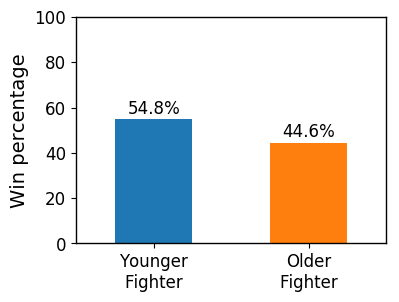

In [26]:
fig, ax = plt.subplots(figsize=(4, 3))
plt.bar([0], 100 * np.array([winner_is_younger, winner_is_older])[0], width=0.5, align='center')
plt.bar([1], 100 * np.array([winner_is_younger, winner_is_older])[1], width=0.5, align='center')
plt.xlim(-0.5, 1.5)
plt.ylim(0, 100)
plt.ylabel('Win percentage')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Younger\nFighter', 'Older\nFighter'])
w_pct_str = '%.1f' % (100 * winner_is_younger)
l_pct_str = '%.1f' % (100 * winner_is_older)
plt.text(1, 47, l_pct_str + '%', ha='center')
plt.text(0, 57, w_pct_str + '%', ha='center')
plt.savefig('report/age/win_pct_younger_older.pdf', bbox_inches='tight')

Check for statistical significance:

In [27]:
af[(af.Dob < af.Dob_L) & (af.Outcome == 'def.')].shape[0]

1716

In [28]:
draws = af[af.Outcome == 'draw'].shape[0]
draws

26

Subtract the draws and the case where both fighters have the same birthday:

In [29]:
p = 2 * binom.cdf(p=0.5, k=1716, n=3850 - 26)
p

2.478556546793075e-10

### What happens if the fight goes the distance? Cardio plays a bigger factor so favors younger?

In [30]:
df.Method.value_counts()

KO/TKO        1384
U-DEC         1329
SUB            888
S-DEC          368
M-DEC           43
Overturned      30
CNC             12
DQ              12
Other            2
Name: Method, dtype: int64

### Maybe long fights are harder on the older fighter (look at decisions only)?

In [31]:
msk = pd.notnull(df.Dob) & pd.notnull(df.Dob_L) & df.Outcome.isin(['def.', 'draw']) & (df.Dob != df.Dob_L) & (df.Method.str.contains('DEC'))
dec = df[msk]
total_fights_dec = dec.shape[0]
total_fights_dec

1718

In [32]:
winner_is_younger_dec = float(dec[(dec.Dob > dec.Dob_L) & (dec.Outcome == 'def.')].shape[0]) / total_fights_dec
winner_is_younger_dec

0.5337601862630966

In [33]:
winner_is_older_dec = float(dec[(dec.Dob < dec.Dob_L) & (dec.Outcome == 'def.')].shape[0]) / total_fights_dec
winner_is_older_dec

0.4522700814901048

### Repeat calculation for different age brackets (with ages rounded to ints)

In [34]:
bk = df[df.Outcome.isin(['def.', 'draw']) & (df.Date > np.datetime64('2005-01-01')) & pd.notnull(df.Dob) & pd.notnull(df.Dob_L)].copy()
#bk['Age'] = (bk.Date - bk.Dob) / np.timedelta64(1, 'Y')
#bk['Age_L'] = (bk.Date - bk.Dob_L) / np.timedelta64(1, 'Y')
bk['Age_int'] = bk.Age.apply(lambda x: round(x)).astype(int)
bk['Age_L_int'] = bk.Age_L.apply(lambda x: round(x)).astype(int)

In [35]:
bk.shape[0]

3550

In [36]:
results = []
brackets = [(18, 24), (25, 29), (30, 34), (35, 39)]
for b_low, b_high in brackets:
     msk = (bk.Age_int <= b_high) & (bk.Age_int >= b_low) & (bk.Age_L_int <= b_high) & (bk.Age_L_int >= b_low)
     younger = bk[(bk.Age_int < bk.Age_L_int) & (bk.Outcome == 'def.') & msk].shape[0]
     older = bk[(bk.Age_int > bk.Age_L_int) & (bk.Outcome == 'def.') & msk].shape[0]
     same = bk[(bk.Age_int == bk.Age_L_int) & (bk.Outcome == 'def.') & msk].shape[0]
     total = float(bk[msk].shape[0])
     total_same = float(bk[(bk.Age_int == bk.Age_L_int) & msk].shape[0])
     results.append(( b_low, b_high, younger, older, younger / (total - total_same), same / (2 * total_same), older / (total - total_same), total, total_same))

In [37]:
def make_label(x):
     return str(int(x[0])) + '-' + str(int(x[1]))

In [38]:
results = pd.DataFrame(results, columns = ['b_low', 'b_high','count_younger','count_older', 'young', 'same', 'old', 'total', 'total_same'])
results['labels_'] = results.apply(make_label, axis=1)
results

,b_low,b_high,count_younger,count_older,young,same,old,total,total_same,labels_
0,18,24,14,14,0.500000,0.500000,0.500000,46.0,18.0,18-24
1,25,29,260,221,0.537190,0.493007,0.456612,627.0,143.0,25-29
2,30,34,218,186,0.538272,0.500000,0.459259,525.0,120.0,30-34
3,35,39,24,27,0.470588,0.500000,0.529412,67.0,16.0,35-39


In [39]:
627-143, 525-120, 67-16

(484, 405, 51)

In [40]:
2*binom.cdf(p=0.5, k=221, n=221+260)

0.083050792827988287

In [41]:
2*binom.cdf(p=0.5, k=186, n=218+186)

0.12289234489494884

In [42]:
2*binom.cdf(p=0.5, k=24, n=24+27)

0.77976793055307492

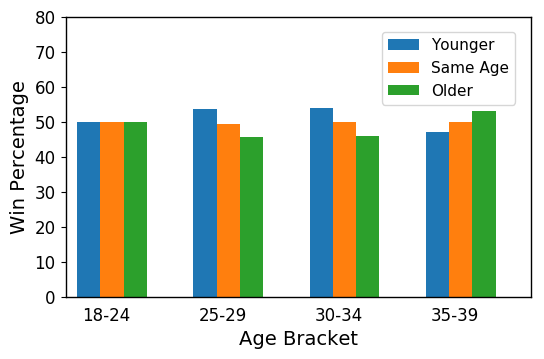

In [43]:
fig, ax = plt.subplots()
left = np.arange(4)
plt.bar(left, 100*results.young, width=0.2, label='Younger')
plt.bar(left + 0.2, 100*results.same, width=0.2, label='Same Age')
plt.bar(left + 0.4, 100*results.old, width=0.2, label='Older')
plt.xlabel('Age Bracket')
plt.ylabel('Win Percentage')
plt.xlim(-0.2, 3.8)
plt.ylim(0, 80)
plt.legend(fontsize=11)
ax.set_xticks(left + 0.15)
ax.set_xticklabels(results.labels_)
ax.xaxis.set_ticks_position('none') 
#plt.savefig('report/age/age_brackets.pdf', bbox_inches='tight')

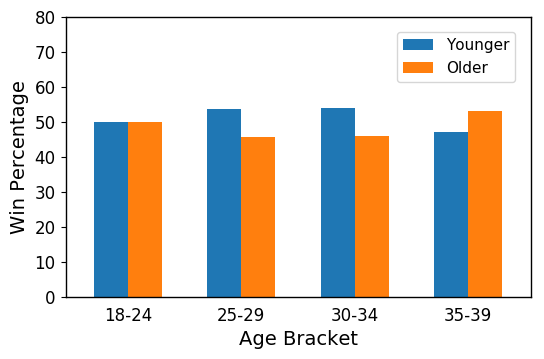

In [44]:
fig, ax = plt.subplots()
left = np.arange(4)
plt.bar(left, 100*results.young, width=0.3, label='Younger')
plt.bar(left + 0.3, 100*results.old, width=0.3, label='Older')
plt.xlabel('Age Bracket')
plt.ylabel('Win Percentage')
plt.xlim(-0.4, 3.7)
plt.ylim(0, 80)
plt.legend(fontsize=11)
ax.set_xticks(left + 0.15)
ax.set_xticklabels(results.labels_)
ax.xaxis.set_ticks_position('none') 
plt.savefig('report/age/age_brackets.pdf', bbox_inches='tight')

### How were wins achieved by age bracket?

In [45]:
df.Method.value_counts()

KO/TKO        1384
U-DEC         1329
SUB            888
S-DEC          368
M-DEC           43
Overturned      30
CNC             12
DQ              12
Other            2
Name: Method, dtype: int64

In [46]:
# remove draws
bk = bk[bk.Outcome == 'def.']

results = []
brackets = [(18, 24), (25, 29), (30, 34), (35, 39)]
for b_low, b_high in brackets:
     msk = (bk.Age_int <= b_high) & (bk.Age_int >= b_low)
     dq = bk[(bk.Method == 'DQ') & msk].shape[0]
     sub = bk[(bk.Method == 'SUB') & msk].shape[0]
     tko = bk[(bk.Method == 'KO/TKO') & msk].shape[0]
     dec = bk[bk.Method.str.contains('DEC') & msk].shape[0]
     total = bk[msk].shape[0]
     results.append((b_low, b_high, tko, sub, dec, dq, total))

In [47]:
results = pd.DataFrame(results, columns = ['b_low', 'b_high', 'tko', 'sub', 'dec', 'dq', 'total'])
results['labels_'] = results.apply(make_label, axis=1)
results

,b_low,b_high,tko,sub,dec,dq,total,labels_
0,18,24,108,102,160,1,371,18-24
1,25,29,496,340,686,1,1523,25-29
2,30,34,424,239,613,7,1283,30-34
3,35,39,126,54,143,0,323,35-39


In [48]:
tmp_table = results.loc[:, 'tko':'dec']
chi_sq, p_value, dof, expect = chi2_contingency(tmp_table)
print chi_sq, dof, p_value, p_value > 0.05

22.3115084806 6 0.00106311576692 False


In [49]:
N = tmp_table.sum().sum()
V = (chi_sq / (N * min(tmp_table.shape[0] - 1, tmp_table.shape[1] - 1)))**0.5
V

0.05652942197328422

In [50]:
results.loc[:, 'tko':'dq'].divide(results.total, axis=0)

,tko,sub,dec,dq
0,0.291105,0.274933,0.431267,0.002695
1,0.325673,0.223244,0.450427,0.000657
2,0.330475,0.186282,0.477786,0.005456
3,0.390093,0.167183,0.442724,0.000000


In [51]:
cont_table = 100 * results.loc[:, 'tko':'dq'].divide(results.total, axis=0).applymap(lambda x: round(x, 3))
cont_table = cont_table.astype(str).applymap(lambda x: x + '%')
cont_table.columns = ['KO/TKO', 'Submission', 'Decision', 'Opponent DQ']
cont_table.index = results.labels_.values
cont_table.to_latex('report/age/finishes_by_age_RAW.tex')
cont_table

,KO/TKO,Submission,Decision,Opponent DQ
18-24,29.1%,27.5%,43.1%,0.3%
25-29,32.6%,22.3%,45.0%,0.1%
30-34,33.0%,18.6%,47.8%,0.5%
35-39,39.0%,16.7%,44.3%,0.0%


Below we check the sums:

In [52]:
results.loc[:, 'tko':'dq'].divide(results.total, axis=0).sum(axis=1)

0    1.0
1    1.0
2    1.0
3    1.0
dtype: float64

### Let's compute win ratios by age bracket

In [53]:
wins = df[df.Outcome.isin(['def.']) & (df.Date > np.datetime64('2005-01-01')) & pd.notnull(df.Dob) & pd.notnull(df.Dob_L)].copy()
#wins['Age'] = (wins.Date - wins.Dob) / np.timedelta64(1, 'Y')
#wins['Age_L'] = (wins.Date - wins.Dob_L) / np.timedelta64(1, 'Y')
wins['Age_int'] = wins.Age.apply(lambda x: round(x)).astype(int)
wins['Age_L_int'] = wins.Age_L.apply(lambda x: round(x)).astype(int)

In [54]:
msk1 = wins.Age < 25
msk2 = wins.Age_L < 25
under25 = float(wins[msk1].shape[0]) / wins[msk1 | msk2].shape[0]
under25

0.6242038216560509

In [55]:
wins[msk1].shape[0], wins[msk2].shape[0]

(490, 371)

In [56]:
2 * binom.cdf(p=0.5, n=wins[msk1].shape[0] + wins[msk2].shape[0], k=min(wins[msk1].shape[0], wins[msk2].shape[0]))

5.6403070046415983e-05

In [57]:
msk1 = (wins.Age >= 25) & (wins.Age <= 29)
msk2 = (wins.Age_L >= 25) & (wins.Age_L <= 29)
over25under30 = float(wins[msk1].shape[0]) / wins[msk1 | msk2].shape[0]
over25under30

0.6313905930470347

In [58]:
wins[msk1].shape[0], wins[msk2].shape[0]

(1235, 1118)

In [59]:
2 * binom.cdf(p=0.5, n=wins[msk1].shape[0] + wins[msk2].shape[0], k=min(wins[msk1].shape[0], wins[msk2].shape[0]))

0.016767285469014539

In [60]:
msk1 = (wins.Age >= 30) & (wins.Age < 35)
msk2 = (wins.Age_L >= 30) & (wins.Age_L < 35)
over30under35 = float(wins[msk1].shape[0]) / wins[msk1 | msk2].shape[0]
over30under35

0.5838264299802761

In [61]:
wins[msk1].shape[0], wins[msk2].shape[0]

(1184, 1310)

In [62]:
2 * binom.cdf(p=0.5, n=wins[msk1].shape[0] + wins[msk2].shape[0], k=min(wins[msk1].shape[0], wins[msk2].shape[0]))

0.012299040431129078

In [63]:
msk1 = wins.Age >= 35
msk2 = wins.Age_L >= 35
over35 = float(wins[msk1].shape[0]) / wins[msk1 | msk2].shape[0]
over35

0.47126436781609193

In [64]:
wins[msk1].shape[0], wins[msk2].shape[0]

(287, 394)

In [65]:
2 * binom.cdf(p=0.5, n=wins[msk1].shape[0] + wins[msk2].shape[0], k=min(wins[msk1].shape[0], wins[msk2].shape[0]))

4.7073513370514293e-05

In [66]:
wins[msk1 & msk2][['Winner', 'Loser', 'Age', 'Age_L']].shape[0]

72

In [67]:
msk1 = (wins.Age > 35) & (wins.Age_L < 35)
msk2 = (wins.Age_L > 35) & (wins.Age < 35)
over35 = float(wins[msk1].shape[0]) / wins[msk1 | msk2].shape[0]
over35

0.40037243947858475

In [68]:
wins[msk1].shape[0], wins[msk2].shape[0]

(215, 322)

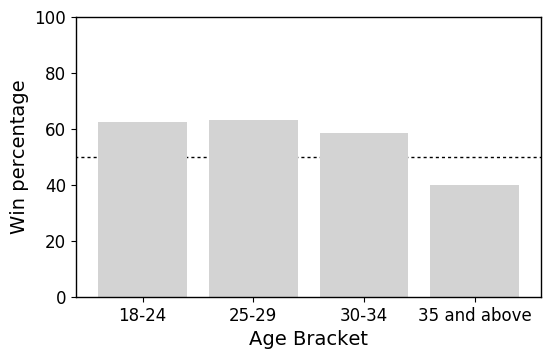

In [69]:
win_percent = [under25, over25under30, over30under35, over35]
labels = ['18-24', '25-29', '30-34', '35 and above']
plt.plot([-1, 4], [50, 50], 'k:', zorder=0)
plt.bar(range(len(win_percent)), 100 * np.array(win_percent), color='lightgray', tick_label=labels, align='center')
plt.xlim(-0.6, 3.6)
plt.ylim(0, 100)
plt.ylabel('Win percentage')
plt.xlabel('Age Bracket')

### What is the winning percentage by age?

In [70]:
win_count_by_age = wins.Age_int.value_counts()

# count fights per age without double counting
ages = win_count_by_age.index
counts = []
for age in ages:
     ct = wins[(wins.Age_int == age) | (wins.Age_L_int == age)].shape[0]
     counts.append(ct)
# total_count_by_age = pd.Series(data=counts, index=ages)
# win percentage is number of wins by age o
total_count_by_age = win_count_by_age + wins.Age_L_int.value_counts()
win_percent_by_age = win_count_by_age / total_count_by_age
cmb = pd.concat([win_count_by_age, total_count_by_age, win_percent_by_age], axis=1).sort_index()
cmb = cmb.loc[20:40]
cmb.columns = ['wins', 'total', 'WinRatio']
cmb['2se'] = -t.ppf(0.025, cmb.total - 1) * (cmb.WinRatio * (1.0 - cmb.WinRatio) / cmb.total)**0.5
cmb

,wins,total,WinRatio,2se
20,10.0,15.0,0.666667,0.261055
21,22.0,37.0,0.594595,0.163698
22,63.0,113.0,0.557522,0.092577
23,115.0,194.0,0.592784,0.069573
24,161.0,295.0,0.545763,0.057052
25,238.0,422.0,0.563981,0.047449
26,274.0,528.0,0.518939,0.042716
27,330.0,594.0,0.555556,0.040042
28,347.0,672.0,0.516369,0.037852
29,334.0,686.0,0.486880,0.037469


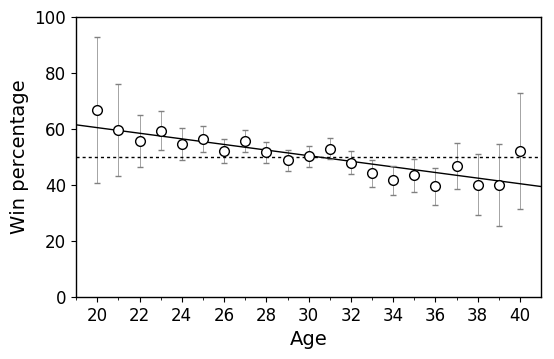

In [71]:
x = cmb.index
y = 100 * cmb.WinRatio.values
xmin = 19
xmax = 41

m, b = np.polyfit(x, y, 1)
fig, ax = plt.subplots()
plt.plot([xmin, xmax], [50, 50], 'k:')
plt.plot(np.linspace(xmin, xmax), m * np.linspace(xmin, xmax) + b, 'k-')
plt.errorbar(cmb.index, 100 * cmb.WinRatio.values, yerr=100*cmb['2se'], fmt='o', marker='o', mec='k', mfc='w', ecolor='gray', elinewidth=0.5, capsize=2)
#plt.plot(cmb.index, 100 * cmb.WinRatio.values, 'wo', mec='k')
plt.xlabel('Age')
plt.ylabel('Win percentage')
plt.xlim(xmin, xmax)
plt.ylim(0, 100)
minor_ticks = np.arange(xmin, xmax, 1)
ax.set_xticks(minor_ticks, minor = True)
major_ticks = np.arange(20, 42, 2)
ax.set_xticks(major_ticks)
ax.set_xticklabels(major_ticks)
plt.savefig('report/age/win_percent_vs_age.pdf', bbox_inches='tight')

Let's check the result for age 40:

In [72]:
float(wins[wins.Age_int == 40].shape[0]) / (wins[wins.Age_int == 40].shape[0] + wins[wins.Age_L_int == 40].shape[0])

0.52

In [73]:
wins[wins.Age_int == 40].shape[0] + wins[wins.Age_L_int == 40].shape[0]

25

In [74]:
from scipy.stats import pearsonr, spearmanr

corr_pearson, p_value_pearson = pearsonr(x, y)
corr_spearman, p_value_spearman = spearmanr(x, y)
print corr_pearson, p_value_pearson
print corr_spearman, p_value_spearman

-0.848240069444 1.19063893348e-06
-0.8437804927 1.53926445477e-06


In [75]:
w = win_count_by_age[total_count_by_age > 20].sort_index()
tot = total_count_by_age[total_count_by_age > 20].sort_index()
cont_table = pd.DataFrame({'wins':w, 'total':tot}).T.sort_index(ascending=False)
cont_table

,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
wins,22.0,63.0,115.0,161.0,238.0,274.0,330.0,347.0,334.0,327.0,342.0,275.0,189.0,150.0,119.0,86.0,68.0,32.0,18.0,13.0
total,37.0,113.0,194.0,295.0,422.0,528.0,594.0,672.0,686.0,652.0,646.0,574.0,429.0,361.0,274.0,218.0,146.0,80.0,45.0,25.0


In [76]:
chi_sq, p_value, dof, expect = chi2_contingency(cont_table)
print chi_sq, p_value, p_value > 0.05

22.9555548185 0.239305088498 True


Below we compute Cramer's V which is a measure of the strength between the two nominal variables:

In [77]:
N = cont_table.sum().sum()
V = (chi_sq / (N * min(2 - 1, 21 - 1)))**0.5
V

0.046770645839261542

The above statistical test indicates that there is not enough data to conclude that the counts for each age are not due to chance. Part of this maybe that the numbers are the largest in the middle where the win ratio is about 50%.

In [78]:
def two_sided_binom(x):
     wins = x[0]
     total = x[1]
     if wins / total == 0.5:
          return 1.0
     elif wins / total < 0.5:
          return 2 * binom.cdf(p=0.5, k=wins, n=total)
     else:
          return 2 * (1.0 - binom.cdf(p=0.5, k=wins-1, n=total))

In [79]:
cont_table.loc['p_value'] = cont_table.apply(two_sided_binom, axis=0)
cont_table.applymap(lambda x: round(x, 2))

,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
wins,22.00,63.00,115.00,161.00,238.00,274.00,330.00,347.00,334.00,327.00,342.00,275.00,189.00,150.0,119.00,86.0,68.00,32.00,18.00,13.0
total,37.00,113.00,194.00,295.00,422.00,528.00,594.00,672.00,686.00,652.00,646.00,574.00,429.00,361.0,274.00,218.0,146.00,80.00,45.00,25.0
p_value,0.32,0.26,0.01,0.13,0.01,0.41,0.01,0.42,0.52,0.97,0.15,0.34,0.02,0.0,0.03,0.0,0.46,0.09,0.23,1.0


We see that when we compute the p_values they are mostly above 0.05.

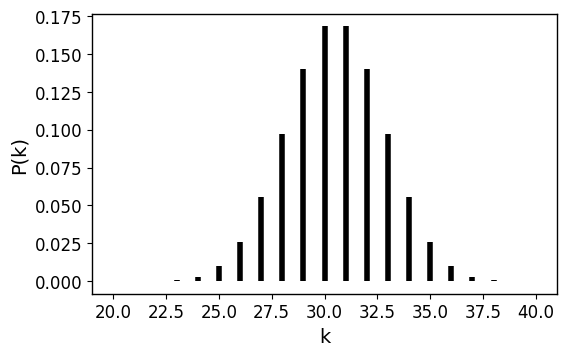

In [80]:
flips = 21
k_values = range(flips + 1)
plt.vlines(x, ymin=0, ymax=[binom.pmf(k, p=0.5, n=flips) for k in k_values], lw=4)
plt.xlabel('k')
plt.ylabel('P(k)')

### Let's compute the win percentage of the younger fighter as a function of age difference:

In [81]:
wins['AgeDiff'] = wins.Age_L - wins.Age
wins.AgeDiff = wins.AgeDiff.apply(round)
delta_age = wins.AgeDiff.value_counts().sort_index()
delta_age

-16.0      1
-15.0      1
-14.0      5
-13.0      9
-12.0     15
-11.0     17
-10.0     28
-9.0      37
-8.0      69
-7.0      97
-6.0     105
-5.0     139
-4.0     169
-3.0     207
-2.0     246
-1.0     287
 0.0     271
 1.0     257
 2.0     289
 3.0     287
 4.0     221
 5.0     185
 6.0     154
 7.0     119
 8.0      96
 9.0      77
 10.0     51
 11.0     29
 12.0     27
 13.0     12
 14.0     11
 15.0      7
 16.0      3
 17.0      2
Name: AgeDiff, dtype: int64

In [82]:
delta_age_overall = np.abs(wins.AgeDiff).value_counts().sort_index()
delta_age_overall

0.0     271
1.0     544
2.0     535
3.0     494
4.0     390
5.0     324
6.0     259
7.0     216
8.0     165
9.0     114
10.0     79
11.0     46
12.0     42
13.0     21
14.0     16
15.0      8
16.0      4
17.0      2
Name: AgeDiff, dtype: int64

In [83]:
younger_diff = delta_age.loc[0:17]
younger_diff

0.0     271
1.0     257
2.0     289
3.0     287
4.0     221
5.0     185
6.0     154
7.0     119
8.0      96
9.0      77
10.0     51
11.0     29
12.0     27
13.0     12
14.0     11
15.0      7
16.0      3
17.0      2
Name: AgeDiff, dtype: int64

In [84]:
cnt = pd.concat([younger_diff, delta_age_overall, younger_diff / delta_age_overall], axis=1).sort_index()
cnt = cnt.loc[1:12]
cnt.columns = ['younger_wins', 'total', 'WinRatio']
cnt['younger_losses'] = cnt.total - cnt.younger_wins
cnt['2se'] = -t.ppf(0.025, cnt.total - 1) * (cnt.WinRatio * (1.0 - cnt.WinRatio) / cnt.total)**0.5
cnt

,younger_wins,total,WinRatio,younger_losses,2se
1.0,257,544,0.472426,287,0.042046
2.0,289,535,0.540187,246,0.042327
3.0,287,494,0.580972,207,0.043617
4.0,221,390,0.566667,169,0.049334
5.0,185,324,0.570988,139,0.054095
6.0,154,259,0.594595,105,0.060075
7.0,119,216,0.550926,97,0.066708
8.0,96,165,0.581818,69,0.075823
9.0,77,114,0.675439,37,0.086879
10.0,51,79,0.645570,28,0.107142


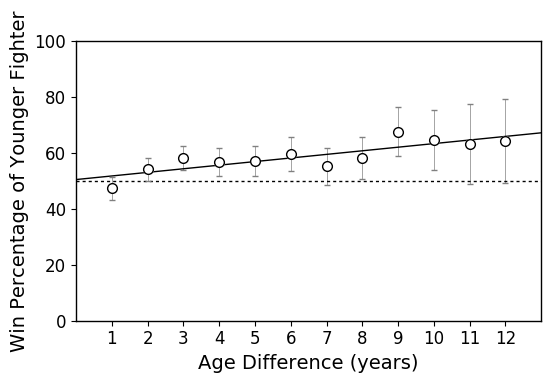

In [85]:
xmin = 0
xmax = 13

m, b = np.polyfit(cnt.index, 100 * cnt.WinRatio, 1)
fig, ax = plt.subplots()
plt.plot([xmin, xmax], [50, 50], 'k:')
plt.plot(np.linspace(xmin, xmax), m * np.linspace(xmin, xmax) + b, 'k-')
plt.errorbar(cnt.index, 100 * cnt.WinRatio.values, fmt='o', color='k', marker='o', mfc='w', yerr=100*cnt['2se'], ecolor='gray', elinewidth=0.5, capsize=2)
plt.plot(cnt.index, 100 * cnt.WinRatio, 'wo')
plt.xlim(xmin, xmax)
plt.xlim(0, 13)
plt.ylim(0, 100)
plt.xticks(range(1, 13))
plt.xlabel('Age Difference (years)')
plt.ylabel('Win Percentage of Younger Fighter')
plt.savefig('report/age/win_percent_of_younger.pdf', bbox_inches='tight')

Let's check the test case of 4:

In [86]:
wins[wins.AgeDiff == 4][['Winner', 'Loser', 'Age', 'Age_L', 'AgeDiff']].shape[0]

221

In [87]:
wins[wins.AgeDiff == -4][['Winner', 'Loser', 'Age', 'Age_L', 'AgeDiff']].shape[0]

169

In [88]:
221 / (221 + 169.0)

0.5666666666666667

This is the correct answer.

In [89]:
corr_pearson, p_value_pearson = pearsonr(x, y)
corr_spearman, p_value_spearman = spearmanr(x, y)
print corr_pearson, p_value_pearson
print corr_spearman, p_value_spearman

-0.848240069444 1.19063893348e-06
-0.8437804927 1.53926445477e-06


When the age difference is 1, we see the null hypothesis of independence holds:

In [90]:
binom.cdf(p=0.5, k=257, n=257+287)

0.10684763884684148

The table below shows that number of wins by the older and younger fighter for the given age difference:

In [91]:
cont_table = cnt[['younger_wins', 'younger_losses']].copy()
cont_table

,younger_wins,younger_losses
1.0,257,287
2.0,289,246
3.0,287,207
4.0,221,169
5.0,185,139
6.0,154,105
7.0,119,97
8.0,96,69
9.0,77,37
10.0,51,28


In [92]:
chi_sq, p_value, dof, expect = chi2_contingency(cont_table)
print chi_sq, p_value, p_value > 0.05

31.1071472157 0.00105919907045 False


In [93]:
N = cont_table.sum().sum()
V = (chi_sq / (N * min(2 - 1, 14 - 1)))**0.5
V

0.098472034866700003

In [94]:
def two_sided_binom(x):
     wins = float(x[0])
     total = x[0] + x[1]
     if wins / total == 0.5:
          return 1.0
     elif wins / total < 0.5:
          return 2 * binom.cdf(p=0.5, k=wins, n=total)
     else:
          return 2 * (1.0 - binom.cdf(p=0.5, k=wins-1, n=total))

In [95]:
cont_table['p_value'] = cont_table.apply(two_sided_binom, axis=1)
cont_table.applymap(lambda x: round(x, 2))

,younger_wins,younger_losses,p_value
1.0,257.0,287.0,0.21
2.0,289.0,246.0,0.07
3.0,287.0,207.0,0.00
4.0,221.0,169.0,0.01
5.0,185.0,139.0,0.01
6.0,154.0,105.0,0.00
7.0,119.0,97.0,0.15
8.0,96.0,69.0,0.04
9.0,77.0,37.0,0.00
10.0,51.0,28.0,0.01


# Youngest and oldest fighters

In [96]:
fights[fights.Winner == 'Robbie Lawler']

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location
527,Robbie Lawler,def.,Carlos Condit,Welterweight,S-DEC,NaN,5,5:00,UFC 195: Lawler vs Condit,2016-01-02,"Las Vegas, Nevada, USA"
765,Robbie Lawler,def.,Rory MacDonald,Welterweight,KO/TKO,Punch,5,1:00,UFC 189: Mendes vs McGregor,2015-07-11,"Las Vegas, Nevada, USA"
1047,Robbie Lawler,def.,Johny Hendricks,Welterweight,S-DEC,NaN,5,5:00,UFC 181: Hendricks vs Lawler II,2014-12-06,"Las Vegas, Nevada, USA"
1218,Robbie Lawler,def.,Matt Brown,Welterweight,U-DEC,NaN,5,5:00,UFC on Fox: Lawler vs Brown,2014-07-26,"San Jose, California, USA"
1339,Robbie Lawler,def.,Jake Ellenberger,Welterweight,KO/TKO,Knee,3,3:06,UFC 173: Barao vs Dillashaw,2014-05-24,"Las Vegas, Nevada, USA"
1560,Robbie Lawler,def.,Rory MacDonald,Welterweight,S-DEC,NaN,3,5:00,UFC 167: St-Pierre vs Hendricks,2013-11-16,"Las Vegas, Nevada, USA"
1704,Robbie Lawler,def.,Bobby Voelker,Welterweight,KO/TKO,Kick,2,0:24,UFC on Fox: Johnson vs Moraga,2013-07-27,"Seattle, Washington, USA"
1848,Robbie Lawler,def.,Josh Koscheck,Welterweight,KO/TKO,Punches,1,3:57,UFC 157: Rousey vs Carmouche,2013-02-23,"Anaheim, California, USA"
3663,Robbie Lawler,def.,Chris Lytle,Welterweight,U-DEC,NaN,3,5:00,UFC 45: Revolution,2003-11-21,"Uncasville, Connecticut, USA"
3704,Robbie Lawler,def.,Tiki Ghosn,Welterweight,KO/TKO,Punch,1,1:29,UFC 40: Vendetta,2002-11-22,"Las Vegas, Nevada, USA"


In [97]:
all_wins = df[pd.notnull(df.Dob)].copy()
all_wins['Age'] = (all_wins.Date - all_wins.Dob) / np.timedelta64(1, 'Y')

all_loses = df[pd.notnull(df.Dob_L)].copy()
all_loses['Age'] = (all_loses.Date - all_loses.Dob_L) / np.timedelta64(1, 'Y')

youngest_winners = all_wins.groupby('Winner').agg({'Age':min})
youngest_losers = all_loses.groupby('Loser').agg({'Age':min})
youngest = youngest_winners.append(youngest_losers).reset_index()
youngest = youngest.groupby('index').agg({'Age':min}).sort_values('Age').applymap(lambda x: round(x, 1)).reset_index()[:30]
youngest

,index,Age
0,Sean Daugherty,18.3
1,Dan Lauzon,18.5
2,Sage Northcutt,19.6
3,Vitor Belfort,19.9
4,Jake Matthews,19.9
5,Larissa Pacheco,20.0
6,Robbie Lawler,20.1
7,Nick Diaz,20.2
8,Max Holloway,20.2
9,Michael McDonald,20.2


In [98]:
oldest_winners = all_wins.groupby('Winner').agg({'Age':max})
oldest_losers = all_loses.groupby('Loser').agg({'Age':max})
oldest = oldest_winners.append(oldest_losers).reset_index()
oldest = oldest.groupby('index').agg({'Age':max}).sort_values('Age', ascending=False).applymap(lambda x: round(x, 1)).reset_index()[:30]
oldest

,index,Age
0,Ron van Clief,51.9
1,Randy Couture,47.9
2,Dan Henderson,46.1
3,Mark Coleman,45.1
4,Anthony Perosh,43.1
5,Renzo Gracie,43.1
6,Ken Shamrock,42.7
7,Mark Hunt,42.3
8,Dan Severn,42.3
9,Cung Le,42.2


In [99]:
young_old = youngest.merge(oldest, left_index=True, right_index=True)
young_old.index = range(1, 31)
young_old.columns = ['Youngest', 'Age', 'Oldest', 'Age']
young_old.to_latex('report/age/youngest_oldest_RAW.tex')
young_old

,Youngest,Age,Oldest,Age
1,Sean Daugherty,18.3,Ron van Clief,51.9
2,Dan Lauzon,18.5,Randy Couture,47.9
3,Sage Northcutt,19.6,Dan Henderson,46.1
4,Vitor Belfort,19.9,Mark Coleman,45.1
5,Jake Matthews,19.9,Anthony Perosh,43.1
6,Larissa Pacheco,20.0,Renzo Gracie,43.1
7,Robbie Lawler,20.1,Ken Shamrock,42.7
8,Nick Diaz,20.2,Mark Hunt,42.3
9,Max Holloway,20.2,Dan Severn,42.3
10,Michael McDonald,20.2,Cung Le,42.2
